In [3]:
%load_ext django_orm_magic

In [4]:
%%django_orm
from django.db import models

class Empresa(models.Model): 
    # aka comercio
    external_id = models.PositiveIntegerField(null=True, blank=True)
    nombre = models.CharField(max_length=80)
    

class Cadena(models.Model):
    # aka Bandera
    external_id = models.PositiveIntegerField()
    empresa = models.ForeignKey('Empresa', on_delete=models.CASCADE)
    nombre = models.CharField(max_length=80)

    
class Sucursal(models.Model):
    external_id = models.CharField(max_length=20, primary_key=True)
    localidad = models.CharField(max_length=80)
    nombre = models.CharField(max_length=50)
    direccion = models.CharField(max_length=100)
    tipo = models.CharField(max_length=20)
    lat = models.FloatField()
    lng = models.FloatField()
    cadena = models.ForeignKey('Cadena', on_delete=models.CASCADE)
    
    
class Marca(models.Model):
    nombre = models.CharField(max_length=80, primary_key=True)
    empresa = models.ForeignKey('Empresa', null=True, on_delete=models.SET_NULL)
    

class Categoria(models.Model):
    nombre = models.CharField(max_length=80)
    
    
class Producto(models.Model):
    codigo = models.CharField(max_length=20, primary_key=True)
    nombre = models.CharField(max_length=150)
    marca = models.ForeignKey('Marca',  on_delete=models.CASCADE)
    categoria = models.ForeignKey('Categoria', null=True, on_delete=models.SET_NULL)
    presentacion = models.CharField(max_length=50)
    
class Relevamiento(models.Model):
    fecha = models.DateField()
    
    
class Precio(models.Model):
    relevamiento = models.ForeignKey(Relevamiento, on_delete=models.CASCADE)
    producto = models.ForeignKey(Producto, on_delete=models.CASCADE)
    sucursal = models.ForeignKey(Sucursal, on_delete=models.CASCADE)
    precio = models.FloatField()  # DecimalField(max_digits=6, decimal_places=2)

In [52]:
from collections import Counter
c = Counter(Sucursal.objects.values_list('localidad', flat=True))
c.most_common(20)


[('Ciudad Autónoma de Buenos Aires', 204),
 ('Capital Federal', 197),
 ('CIUDAD AUTONOMA BUENOS AIRES', 44),
 ('Mar Del Plata', 27),
 ('Bahía Blanca', 25),
 ('Salta', 25),
 ('Capital', 21),
 ('Rosario', 17),
 ('Neuquen', 17),
 ('Ciudad Autonoma de Buenos Aires', 16),
 ('CAPITAL FEDERAL', 13),
 ('Lanus', 13),
 ('Tigre', 12),
 ('SAN MIGUEL DE TUCUMAN', 11),
 ('San Luis', 10),
 ('Santa Rosa', 9),
 ('San Martin', 8),
 ('Lomas De Zamora', 8),
 ('MENDOZA', 8),
 ('Guaymallen', 8)]

In [3]:
import pandas as pd

In [4]:
Relevamiento.objects.values_list('fecha', flat=True)

<QuerySet [datetime.date(2018, 4, 20), datetime.date(2018, 4, 29), datetime.date(2018, 5, 8), datetime.date(2018, 5, 15), datetime.date(2018, 5, 22)]>

In [6]:
relevamientos = list(Relevamiento.objects.all())

In [7]:
from django.db.models import DateTimeField, ExpressionWrapper, F, Q

In [25]:
precios_abril = relevamientos[0].precio_set
precios_mayo = relevamientos[-1].precio_set
precios_abril.count(), precios_mayo.count(), 

(6441097, 5989746)

In [27]:
columns = ['producto_id', 'sucursal_id', 'precio']
pd_abril = pd.DataFrame.from_records(list(precios_abril.values_list(*columns)), columns=columns)
pd_mayo = pd.DataFrame.from_records(list(precios_mayo.values_list(*columns)), columns=columns)

In [28]:
cruce = pd.merge(pd_abril, pd_mayo, on=['producto_id', 'sucursal_id'], suffixes=('_abril', '_mayo'))
cruce

,producto_id,sucursal_id,precio_abril,precio_mayo
0,7790080065183,9-2-12,22.45,22.45
1,7791337651227,9-2-12,22.99,23.99
2,7791337690820,9-2-12,40.00,40.00
3,7790080065152,9-2-12,19.99,19.99
4,7790080065169,9-2-12,19.99,19.99
5,7790080065190,9-2-12,22.45,22.45
6,7791337601215,9-2-12,22.99,23.99
7,7791337690813,9-2-12,40.00,40.00
8,7791337695726,9-2-12,40.00,40.00
9,7790080065145,9-2-12,22.49,22.99


In [29]:
cruce['aumento'] = (cruce['precio_mayo'] - cruce['precio_abril']) * 100 / cruce['precio_abril']
cruce

,producto_id,sucursal_id,precio_abril,precio_mayo,aumento
0,7790080065183,9-2-12,22.45,22.45,0.000000
1,7791337651227,9-2-12,22.99,23.99,4.349717
2,7791337690820,9-2-12,40.00,40.00,0.000000
3,7790080065152,9-2-12,19.99,19.99,0.000000
4,7790080065169,9-2-12,19.99,19.99,0.000000
5,7790080065190,9-2-12,22.45,22.45,0.000000
6,7791337601215,9-2-12,22.99,23.99,4.349717
7,7791337690813,9-2-12,40.00,40.00,0.000000
8,7791337695726,9-2-12,40.00,40.00,0.000000
9,7790080065145,9-2-12,22.49,22.99,2.223210


In [60]:
%matplotlib inline


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6232e5dd68>]], dtype=object)

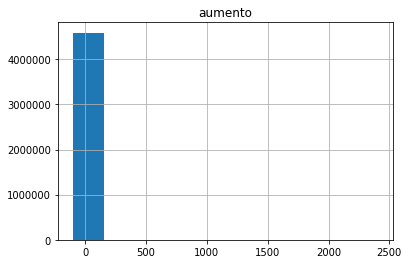

In [61]:
cruce.hist('aumento')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f62332f4358>]], dtype=object)

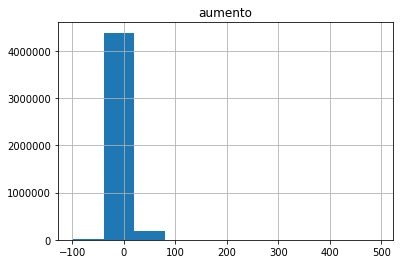

In [63]:
cruce.loc[(cruce.aumento >= -500) & (cruce.aumento <= 500)].hist('aumento')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f621b7e4908>]], dtype=object)

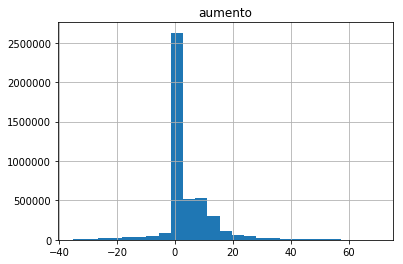

In [71]:
cruce_sin_extremos = cruce.loc[(cruce.aumento >= -35) & (cruce.aumento <= 70)]
cruce_sin_extremos.hist('aumento', bins=25)

In [83]:
sucs = pd.DataFrame.from_records(
    list(Sucursal.objects.values_list('external_id', 'cadena__nombre', 'cadena__empresa__nombre')),
    columns=['sucursal_id', 'cadena', 'empresa']
)


In [96]:
provs = pd.read_csv('datasets/sucursales.csv', usecols=['provincia','sucursalId', 'comercioId', 'banderaId'])
provs['sucursal_id'] = provs.apply(lambda x: f"{x['comercioId']}-{x['banderaId']}-{x['sucursalId']}", axis=1)
provs.drop(['sucursalId', 'comercioId', 'banderaId'], axis=1, inplace=True)
sucs = pd.merge(sucs, provs, on='sucursal_id')

In [97]:
prods = pd.DataFrame.from_records(list(Producto.objects.values_list('codigo', 'marca')), columns=['producto_id', 'marca'])
con_marca = pd.merge(cruce_sin_extremos, prods, on='producto_id')
con_marca_cadena_y_prov = pd.merge(con_marca, sucs, on='sucursal_id')
con_marca_cadena_y_prov

,producto_id,sucursal_id,precio_abril,precio_mayo,aumento,marca,cadena,empresa,provincia_x,provincia_y
0,7790080065183,9-2-12,22.45,22.45,0.000000,YOGS,Disco,Jumbo Retail Argentina S.A.,AR-C,AR-C
1,7791337651227,9-2-12,22.99,23.99,4.349717,YOGURISIMO,Disco,Jumbo Retail Argentina S.A.,AR-C,AR-C
2,7791337690820,9-2-12,40.00,40.00,0.000000,YOGURISIMO,Disco,Jumbo Retail Argentina S.A.,AR-C,AR-C
3,7790080065152,9-2-12,19.99,19.99,0.000000,YOGS,Disco,Jumbo Retail Argentina S.A.,AR-C,AR-C
4,7790080065169,9-2-12,19.99,19.99,0.000000,YOGS,Disco,Jumbo Retail Argentina S.A.,AR-C,AR-C
5,7790080065190,9-2-12,22.45,22.45,0.000000,YOGS,Disco,Jumbo Retail Argentina S.A.,AR-C,AR-C
6,7791337601215,9-2-12,22.99,23.99,4.349717,YOGURISIMO,Disco,Jumbo Retail Argentina S.A.,AR-C,AR-C
7,7791337690813,9-2-12,40.00,40.00,0.000000,YOGURISIMO,Disco,Jumbo Retail Argentina S.A.,AR-C,AR-C
8,7791337695726,9-2-12,40.00,40.00,0.000000,YOGURISIMO,Disco,Jumbo Retail Argentina S.A.,AR-C,AR-C
9,7790080065145,9-2-12,22.49,22.99,2.223210,YOGS,Disco,Jumbo Retail Argentina S.A.,AR-C,AR-C


In [119]:
data = con_marca_cadena_y_prov

In [154]:
data.aumento.describe()

count    4.880951e+06
mean     3.722366e+00
std      8.937182e+00
min     -3.500000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      7.246377e+00
max      7.000000e+01
Name: aumento, dtype: float64

INDICE OpenDataCórdoba DE PRECIOS ABRIL/MAYO: 3.72%

In [125]:
prods

,producto_id,marca
0,7790080065107,YOGS
1,7790080065183,YOGS
2,7791337651227,YOGURISIMO
3,7791337690820,YOGURISIMO
4,7790080065121,YOGS
5,7790080065152,YOGS
6,7790080065169,YOGS
7,7790080065190,YOGS
8,7791337601215,YOGURISIMO
9,7791337690813,YOGURISIMO


In [ ]:
df.

In [130]:
by_marca = data.groupby('marca').aumento.mean()
by_marca_count =  prods.groupby('marca').count()

por_marcas = by_marca.to_frame('aumento').join(by_marca_count.producto_id.to_frame('cantidad_prods'))

In [134]:
por_marcas['cantidad_prods'].describe()

count    4787.000000
mean       11.528724
std       101.261185
min         1.000000
25%         1.000000
50%         3.000000
75%         8.000000
max      6607.000000
Name: cantidad_prods, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6225bd7320>]], dtype=object)

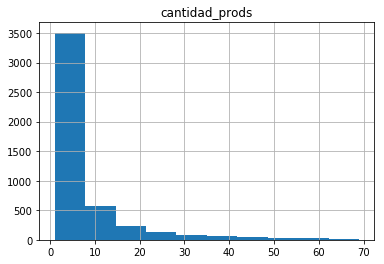

In [140]:
por_marcas_hasta_70 = por_marcas.loc[(por_marcas['cantidad_prods'] < 70)]
por_marcas_hasta_70.hist('cantidad_prods')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6212e71e80>]], dtype=object)

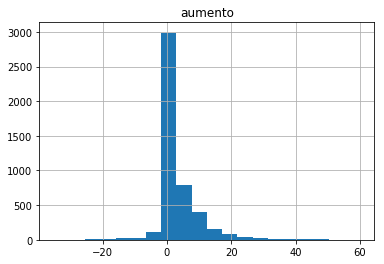

In [143]:
por_marcas_hasta_70.hist('aumento', bins=20)

In [145]:
por_marcas_hasta_70.sort_values('aumento', ascending=False)[:20]

,aumento,cantidad_prods
marca,,
DROSTE,59.760932,6
LOURISIERRA,58.748019,2
MARTINS,56.550961,5
TRIGALIA,54.260870,1
PENTY,54.074074,2
BARIL,52.595332,1
EL PASTOR,50.387067,5
SAN DANIELE,50.050050,2
LACTEOS CERRI,47.058824,2


In [8]:
import pandas as pd

In [10]:
pd.Series(Producto.objects.filter(marca__nombre='JOSIMAR').values_list('nombre', flat=True))

0                            Trenza de Grasa Chica 1 Kg
1                                  Torta Chocolate 1 Un
2                          Torta de Crema y Cereza 1 Un
3                         Torta de Crema y Durazno 1 Un
4                                     Torta Molino 1 Un
5        Tarta Copos de Dulce de Leche y Chocolate 1 Un
6                                    Tarta de Coco 1 Un
7     Tarta de Copos de Dulce de Leche con Chocolate...
8                                   Tarta de Fruta 1 Un
9                                    Tarta Manzana 1 Un
10                                    Tarta Ricota 1 Un
11                                    Tarta Ricota 1 Un
12                 Tarta Ricota con Dulce de Leche 1 Un
13                                    Sopa Inglesa 1 Un
14                                    Sopa Inglesa 1 Un
15                               Pre Pizza Cebolla 1 Un
16                               Pre Pizzas Tomate 1 Un
17                                         Piono

Aumentos

In [159]:
pd.set_option('max_rows', 150)
por_marcas.loc[(por_marcas['cantidad_prods'] > 15)].sort_values('aumento', ascending=False)[:150]

,aumento,cantidad_prods
marca,,
IGEA,28.288991,33
JOSIMAR,26.501900,55
ESTRELLA DEL PARANA,25.160736,17
FAVORITA,24.232107,17
BARBARA,21.976379,33
FRUTAS DEL SUR,21.320491,17
MENDIA,20.985276,47
LA PORTEÑA,19.365616,16
MAYBELLINE,17.685950,140


falta el dato de fabricante de cada marca. salta a la vista que Arcor rondó el 6% de aumento

## Aumentos por cadena

In [164]:
data.groupby('cadena').aumento.mean().sort_values(ascending=False).to_frame('aumento')

,aumento
cadena,
DEHEZA S.A.I.C.F. e I.,10.592771
JOSIMAR SUPERMERCADOS,10.296051
FULL,6.639613
Toledo,6.547116
Vea,6.139008
Disco,4.288037
COTO CICSA,4.067768
Jumbo,4.016594
LA AGRICOLA REGIONAL COOPERATIVA LIMITADA,3.938066


In [165]:
data.groupby('empresa').aumento.mean().sort_values(ascending=False).to_frame('aumento')

,aumento
empresa,
Deheza S.A.I.C.F. e I.,10.592771
Josimar S.A.,10.296051
Operadora de Estaciones de Servicios S.A.,6.639613
Supermercados Toledo S.A.,6.547116
Jumbo Retail Argentina S.A.,5.275795
Coto Centro Integral de Comercialización S.A.,4.067768
La Agricola Regional Cooperativa Limitada,3.938066
SUPERCLC S.A.,3.885433
DIA Argentina S.A,3.520039


### Por provincia

In [172]:
pd.read_html('https://es.wikipedia.org/wiki/ISO_3166-2:AR')

ImportError: lxml not found, please install it

In [169]:
!pip install lxml

    100% |████████████████████████████████| 5.7MB 205kB/s ta 0:00:01   2% |█                               | 163kB 1.2MB/s eta 0:00:05
You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [171]:
import lxml

4

In [167]:
data.groupby('provincia_x').aumento.mean().sort_values(ascending=False).to_frame('aumento')

,aumento
provincia_x,
AR-M,5.552788
AR-F,5.028067
AR-T,4.992299
AR-K,4.914981
AR-G,4.571794
AR-D,3.968613
AR-E,3.880488
AR-B,3.687618
AR-C,3.578544
